# Prepare the Dataset

Before training the machine learning, we have to load the dataset. The dataset here is in ZIP and we have to unzip it first.

In [ ]:
import zipfile

dataset_path = # path of the dataset 
zip_ref = zipfile.ZipFile(dataset_path, 'r')
zip_ref.extractall(# the location of the unzip file)
zip_ref.close()

# Import the Python Library
Here we load all the library needed to training the machine learning model.

In [ ]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# Prepare the Data to be Loaded to the Machine Learning.


1.   Preprocess the images (normalizing, shear, rotate, etc.)
2.   Load the data to the dataset generator
3.	 Checking all the label in the dataset and the number of image for training and validation


In [ ]:
base_dir = # path of the dataset folder
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')

# data preprocessing 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=90,
    fill_mode='reflect',
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224,224),
    class_mode='categorical',
    batch_size= 30,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb'
)
cloth_dict = train_generator.class_indices
print(cloth_dict)

Found 6000 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
{'0': 0, '1': 1, '10': 2, '11': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11}


# Transfer Learning with MobileNetV2
Since our dataset is quite small (500 for training and 100 for validation), to increase the effectiveness and accuracy of the model, we will utilizing transfer learning.

In [ ]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=1.0,
    pooling='avg' # Add GlobalAvgPool2D() layer as its final layer
)

base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


# Training the Machine Learning Model

1.   Create the scheduler function the control the learning rate for each epoch
2.   Define the learning rate, epoch, training steps and validation steps
3.	 Create the ML model with the transfer learning as the base layer.
4.   See the summary and run the model


In [1]:
def scheduler(epoch, lr):
  if epoch <= 15:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

NameError: ignored

In [ ]:
EPOCHS = 70
LEARNING_RATE = 1e-4
TRAIN_STEP = train_generator.n//train_generator.batch_size
VAL_STEP = validation_generator.n//validation_generator.batch_size

In [ ]:
clear_session()

model = Sequential([
    base_model,
    Dense(256, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    Dense(256, activation='relu'),
    Dense(12, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=TRAIN_STEP,
    validation_steps=VAL_STEP,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[lr_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 12)                3084      
                                                                 
Total params: 2,654,796
Trainable params: 396,812
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/70
200/200 [==============================] - 96s 416ms/step - loss: 2.1349 - accuracy: 0.3567 - v

# Analyzing the Training Result
After the training, here we will see the result in form of graph.

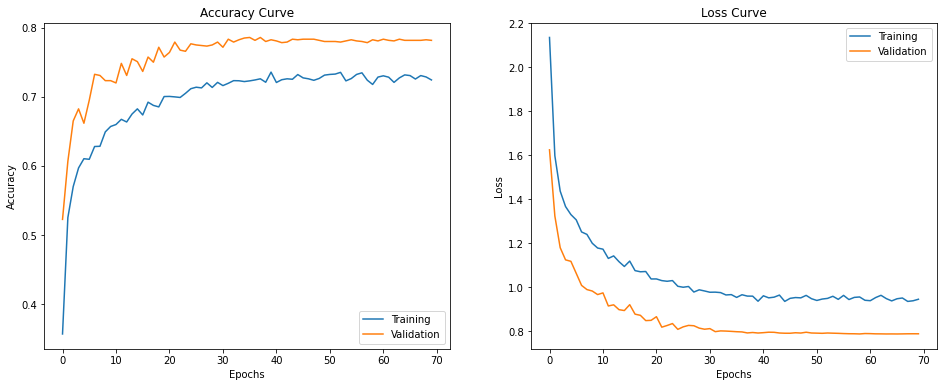

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

# Check the Accuracy for Each Class
Here we will check the accuracy for each class, so we can imporove the performance of the machine learning.

In [ ]:
test_path=# path of the test folder

for cloth in cloth_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, cloth))    
    # plt.figure(figsize=(16, 20))

    correct_count = 0

    for idx, image in enumerate(images_list):
        img_path = f'/test_path/{cloth}/{image}'
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img) / 255.0
        img_array = tf.expand_dims(img_array, 0)

        cloth_list = list(cloth_dict.keys())
        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_cloth = cloth_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_cloth == cloth:
            correct_count += 1
    
    print(f'{cloth} Predictions --> {correct_count}/100 correct')

0 Predictions --> 75/100 correct
1 Predictions --> 74/100 correct
10 Predictions --> 84/100 correct
11 Predictions --> 71/100 correct
2 Predictions --> 71/100 correct
3 Predictions --> 95/100 correct
4 Predictions --> 76/100 correct
5 Predictions --> 69/100 correct
6 Predictions --> 77/100 correct
7 Predictions --> 67/100 correct
8 Predictions --> 90/100 correct
9 Predictions --> 89/100 correct


# Saved the model to TensorFlow Lite
To deploy the ML model in android you have to convert it to Tensorflow Lite. Here you can also save the model to deploy it with Tensorflow Serving

In [ ]:
import os
import pathlib

# Saved the model
model_version = # the version, default is 1
model_save = # name of the model
model_path = os.path.join(model_save, model_version)
tf.saved_model.save(model, model_path)
# Stop here if you want to deploy it using Tensorflow Serving

# Convert the model to TF lite
converter = tf.lite.TFLiteConverter.from_saved_model(model_path) # path to the SavedModel directory
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: D-Jahit/1/assets


INFO:tensorflow:Assets written to: D-Jahit/1/assets


10456596

# ZIP the Result
After saving the model, you can zip the folder and download it

In [ ]:
scr_path= # path to the saved model folder
dest_path= # path to save the zip file
import shutil
shutil.make_archive(dest_path, 'zip', scr_path )

'/content/drive/MyDrive/Capstone_Project.zip'